In [1]:
# Import Packages

# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from numpy.polynomial.polynomial import polyfit
import seaborn as sns

# Set Seaborn's Color Palette
sns.set_palette(sns.color_palette("muted", 30))

# Modeling 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Validation 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix
import imblearn


Gather and Visualize Data

Once we have the data it will be useful to have a look at its distribution as well as try to identify any outliers that may exist. As we do so, it will also be important to make note of Kaggle's documentation of the dataset. This will help us interpret outliers, and give us an idea of the best way to use the data for modeling.

Kaggle submissions are formatted as two-column datasets with an identifier column (the "Id" variable from the test dataset) and a prediction column, predicted by training a model on the training dataset. To get started, I'll read in both datasets, define the target variable for later ("y"), and also define the identifier variable that I'll use later when making the final submission ("Id").

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y = train_df.loc[(train_df['parentesco1']==1), 'Target']
Id = test_df.Id
train_df.shape[0]

9557

In [3]:
len(train_df.columns)

143

In [4]:
test_df.shape[0]

23856

In [5]:
pd.set_option('display.max_columns', 150)
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Nice. Now we have the data loaded in properly and can see that our test set has a sizeable sample of just under 10,000 observations. In addition, we have 143 features to choose from to build our prediction model. 

Now that's out of the way, we can start getting a feel for what these data can tell us right away with some useful visualizations. We will also look at some relationships between choice variables and try to learn which ones can tell us the most about our target variable. We're going to focus on the training set so that we don't jump the gun and head straight to overfitting. That will probably happen anyway, but we are going to try to avoid it as best as we can. 

First we are going to look at the distribution of our target variable, Poverty Level (categorized by income levels):

([<matplotlib.axis.XTick at 0x1a215c86d8>,
 <a list of 4 Text xticklabel objects>)

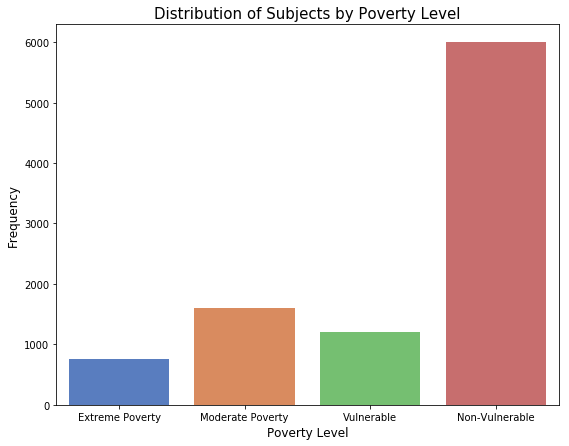

In [6]:
# Bar Chart of Target Variable (Poverty Level)
f, ax = plt.subplots(figsize=(9, 7))
sns.countplot(train_df.Target)
plt.title('Distribution of Subjects by Poverty Level', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])

Fortunately, extreme poverty is the smallest of the four categories. Most people are categorized as Non-Vulnerable, skewing our data to the left. It's a good thing that we have a lot of variables to help us build a model, as we are going to rely on them heavily to accurately predict poverty levels.

Going with economic intuition, we're going to have a look at how education and poverty levels interact with each other. We should expect to see a negative relationship (as education levels increase, poverty levels decrease).

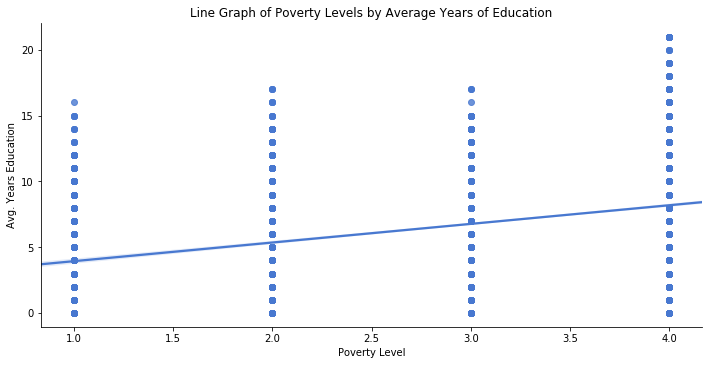

In [7]:
#Years of Education by Poverty Level
sns.lmplot(x = 'Target', y = 'escolari', data = train_df, aspect = 2)
plt.title('Line Graph of Poverty Levels by Average Years of Education')
plt.ylabel('Avg. Years Education')
plt.xlabel('Poverty Level')
plt.show()

Whew. Economics isn't broken yet. We do observe a positive relationship between education and poverty. Also worthy of note, is that we see larger variation in education levels at the non-vulnerable level. This is good news for our model because it is highly unlikely for someone to have 20 years of education and be at the worst level of poverty. This will help our model learn how to effectively classify people. 

Again, we will use economic intuition to help us to learn more about our data: there are likely a larger share of children per households in poverty. Let's look at a boxplot and see.

In [8]:
#Quick Function that Spits Out a Box Plot
def box_out(x):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.boxplot(x = 'Target', y = x, data = train_df)
    plt.xlabel('Poverty Level')

Number of Children Grouped by Income Levels


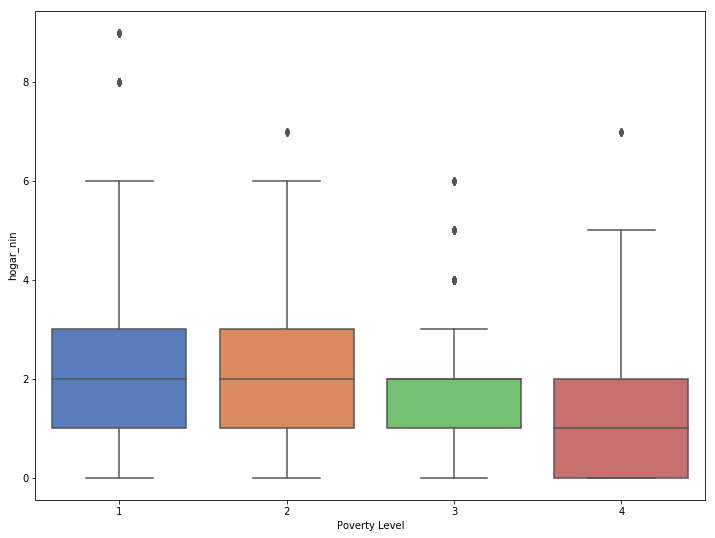

In [9]:
print("Number of Children Grouped by Income Levels")
box_out('hogar_nin')

We can see some confirmation of our theory: on average there tend to be slightly fewer children per household as income levels rise. However, the distribution of the number of children at each level varies markedly in most cases. We should also point out that there are some extreme outliers in the extreme poverty level of 8 and 9 children per household.

Price signaling (yet another economic concept) may be useful in helping us predict poverty levels. We have a variable for Monthly Mortgage Payments for each level of poverty. Let's see what that looks like. 

Monthly Mortgage Payments


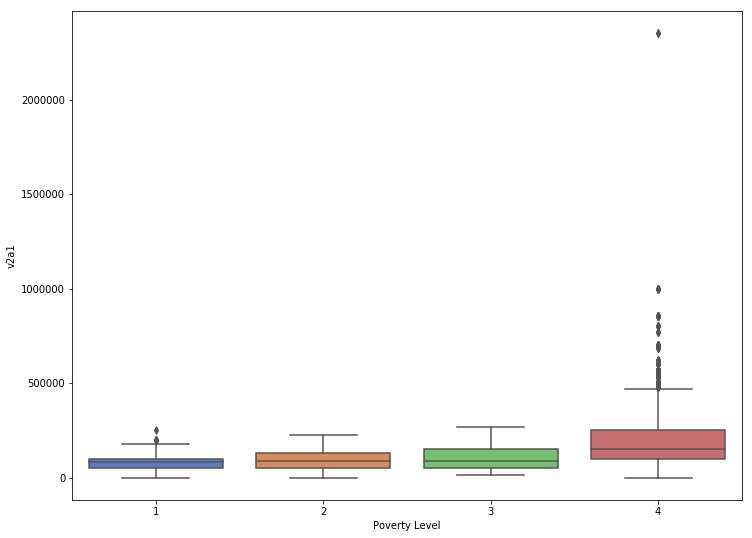

In [10]:
print("Monthly Mortgage Payments")
box_out('v2a1')

Whoa. Got some outliers in there for sure in the non-vulnerable poverty level. This shouldn't surpise us, as wealthy (and extremely wealthy) people are going to all fall into our non-vulnerable category as we have a natural lower bound of 0 and no upper limit in our classification of poverty levels.

But other than that, we can pat ourselves on the back (again) for our economic intuition being correct. We see a (somewhat exponential looking) posive relationship between Monthly Mortgage Payments and poverty levels. Looking good so far with what we have examined; we should be fairly confident that we have some meaningful relationships to work with in constructing an effective model.

Next, we will have a look at the proportion of houeseholds with various types of floor as another signal of income level.

In [11]:
print("Proportion of Mosaic/Ceramic/Terrazo Floors by Income Group (in percentages)")
cross_tab_floors = pd.crosstab(train_df['Target'], train_df['pisomoscer'])
cross_tab_floors_proportion = (cross_tab_floors[0]+cross_tab_floors[1])
cross_tab_floors_proportion = (cross_tab_floors[1]/cross_tab_floors_proportion)*100
print(cross_tab_floors_proportion)


Proportion of Mosaic/Ceramic/Terrazo Floors by Income Group (in percentages)
Target
1    46.622517
2    49.405135
3    61.042184
4    79.086057
dtype: float64


This looks useful. We can see that there's an increasing proportion of homeowners with Mosaic/Ceramic/Terrazo floors as income level rises. Let's have a look at this same relationship again, but with cement floors only this time.

In [12]:
print("Proportion of Cement Floors by Income Group (in percentages)")
cross_tab_cement = pd.crosstab(train_df['Target'], train_df['pisocemento'])
cross_tab_cement_proportion = (cross_tab_cement[0]+cross_tab_cement[1])
cross_tab_cement_proportion = (cross_tab_cement[1]/cross_tab_cement_proportion)*100
print(cross_tab_cement_proportion)

Proportion of Cement Floors by Income Group (in percentages)
Target
1    37.748344
2    35.128366
3    27.626137
4    15.843896
dtype: float64


It seems that cement floors are an inferior good, as we see the proportion of homeowners with cement floors drop as income levels rise. 

We've been able to learn about some relationships between our target variable, Poverty Level, and some other variables in our dataset. Now we can move onto cleaning the data and feature engineering so that we can start building our model.

Data Cleaning and Feature Engineering

The glaring problem that we will tackle first is missing data. We are going to impute missing data as best as we can. Next, we will make sure that our variables display values in a way that are ready for prediction modeling. We are going to combine the training and the test set so that our imputation is consistent across both datasets.

In [13]:
# Combining the training and the test set
ntrain = train_df.shape[0]
full_df = pd.concat((train_df.drop('Target', axis = 1), test_df)).reset_index(drop = True)
full_df = full_df.drop('Id', axis = 1)

In [14]:
full_df.shape

(33413, 141)

How much missind data do we have? This should help us with that:

In [15]:
full_df.isna().sum().sort_values(ascending = False)

rez_esc            27581
v18q1              25468
v2a1               24263
meaneduc              36
SQBmeaned             36
v14a                   0
sanitario6             0
techocane              0
techootro              0
cielorazo              0
abastaguadentro        0
abastaguafuera         0
abastaguano            0
public                 0
planpri                0
noelec                 0
coopele                0
sanitario1             0
sanitario2             0
sanitario3             0
sanitario5             0
energcocinar1          0
refrig                 0
energcocinar2          0
energcocinar3          0
energcocinar4          0
elimbasu1              0
elimbasu2              0
elimbasu3              0
elimbasu4              0
                   ...  
parentesco2            0
parentesco1            0
estadocivil7           0
estadocivil6           0
estadocivil4           0
instlevel2             0
estadocivil3           0
estadocivil2           0
estadocivil1           0


Not too bad, save the top thee which are missing quite a lot of data, and 4 and 5 are missing a little. Here's some definitions of each variable:

rez_esc - Years behind in school
v18q1 - Number of tablets in the household
v2a1 - Monthly rent
meaneduc - Average years of education for adults in the household
SQBmeaned - Average years of education for adults in the household squared

Let's find out what's going on with the variable, "Number of Tablets in the House"

In [16]:
full_df['v18q1'].head(10)

0    NaN
1    1.0
2    NaN
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
8    NaN
9    NaN
Name: v18q1, dtype: float64

In [17]:
full_df['v18q1'].value_counts()

1.0    5883
2.0    1449
3.0     447
4.0     125
5.0      31
6.0      10
Name: v18q1, dtype: int64

In this variable, NaN means that the household does not have any tablets. Also, there's a dummy variable that shows whether there is a positive number of tablets in the household. 0 means there are none.

In [18]:
full_df['v18q'].head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    0
9    0
Name: v18q, dtype: int64

In [19]:
full_df.v18q1 = full_df.v18q1.fillna(0)

Next, we'll investigate mean education. All we know from Kaggle is that it's the average level of education in the household, so we can't make a lot of assumptions with that information. Let's see what they look like:

In [20]:
full_df.loc[(full_df['SQBmeaned'].isnull()) & (full_df['meaneduc'].isnull())]

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
1291,NaN,0,7,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1b31fd159,1,0,0,1,8,no,10,NaN,0,0,0,1,0,0,0,0,0,5,0.200000,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.040000,64.0,NaN,324
1840,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,0,1,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.000000,64.0,NaN,324
1841,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,1,0,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.000000,64.0,NaN,324
2049,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361
2050,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361
9561,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.500000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.250000,64.0,NaN,324
10092,399378.0,0,6,0,1,0,1,3.0,0,0,0,0,1,1,0,1,1,1,4,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,bb7038e41,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,4,1.000000,0,0,1,0,0,0,1,1,4,1,0,0,0,0,0,1,0,18,121,324,1,0,1,1.000000,64.0,NaN,324
10093,180000.0,0,4,0,1,1,0,0.0,0,0,0,0,2,2,0,2,2,2,2,12,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,4937daf94,2,0,0,2,8,no,12,NaN,0,0,0,0,0,0,0,1,0,2,1.000000,0,0,1,0,0,0,0,

Since there are so few missing from the total in our set, we will just go ahead an impute the missing values with the median of the variable. I don't think that there are going to be drastic consequences in doing this since we have so much data.

In [21]:
# Imputing Missing "Mean Education" Values with Median of "Years of Schooling" Group
full_df['meaneduc'] = full_df.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))

# Filling in "Mean Education Squared"
full_df['SQBmeaned'] = (full_df.meaneduc)**2

Lets look at years behind in school against age and see what's going on:

In [22]:
pd.crosstab(full_df['rez_esc'], full_df['age'])

age,7,8,9,10,11,12,13,14,15,16,17
rez_esc,,,,,,,,,,,
0.0,478,512,480,456,374,433,454,377,329,326,255
1.0,0,18,33,58,55,69,60,97,113,119,106
2.0,0,0,2,5,12,21,21,24,76,91,84
3.0,0,0,0,4,3,6,5,6,8,75,67
4.0,0,0,0,0,1,1,1,0,1,7,69
5.0,0,0,0,0,0,5,3,5,4,9,13
99.0,0,1,0,0,0,0,0,0,0,0,0


Here, we can see two things: first, a relevant age range (7 to 17) indicating that years behind in school is dependent upon your age and what is possible in terms of school at that point. Second, is a value of 99 years behind in school? This is most likely an indication of missing data. Let's drop it.

In [23]:
# Impute 0 for Not-In-School Observations in "Years Behind" 
full_df.loc[((full_df['age'] >= 17) | (full_df['age'] < 7)) & (full_df['rez_esc'].isnull()), 'rez_esc'] = 0

# Impute 0 where rez_esc = 99
full_df.loc[(full_df['rez_esc'] == 99)] = 0

# Checks remaining Missing Values
full_df['rez_esc'].isna().sum()

5

5 left. I think we can safely go with the same strategy as before and impute with the median without increasing the risk of cancer.

In [24]:
# Imputes Missing "Years Behind" Values with Median of "Mean Education"
full_df['rez_esc'] = full_df.groupby('meaneduc')['rez_esc'].transform(lambda x: x.fillna(x.median()))

Last one: Rent Payments. This one's a little trickier, but we can try to see what's going on by looking at where the data is missing for this variable and then looking at some other variables about home ownership and see what they look like in comparison. 

In [25]:
# Create Binary Variable for Missing Data
full_df['missing_rent'] = 0
full_df.loc[(full_df.v2a1.isnull()), 'missing_rent'] = 1

# Create an Ownership Status Variable Made of Condensed Dummies
full_df['own_status'] = "NaN"
full_df.loc[(full_df.tipovivi1 == 1), 'own_status'] = "Own, Fully Paid"
full_df.loc[(full_df.tipovivi2 == 1), 'own_status'] = "Own, Paying in Installments"
full_df.loc[(full_df.tipovivi3 == 1), 'own_status'] = "Rented"
full_df.loc[(full_df.tipovivi4 == 1), 'own_status'] = "Precarious"
full_df.loc[(full_df.tipovivi5 == 1), 'own_status'] = "Other (Assigned, Borrowed)"

# Cross-Tab
pd.crosstab(full_df['missing_rent'], full_df['own_status'])

own_status,NaN,"Other (Assigned, Borrowed)","Own, Fully Paid","Own, Paying in Installments",Precarious,Rented
missing_rent,,,,,,
0,1,0,0,3497,0,5652
1,0,2822,20844,0,597,0


Lucky us, from this we learn that a large fraction of the missing data is on people who own their home and therefore do not have a monthly payment! We can impute these guys with 0's and happily forget about them. 

The rest... you guessed it. Impute the median. This time we may indeed be increasing the risk of cancer, but we don't have a lot of other options as we have limited information available. 

In [26]:
# Impute 0 for homeowners
full_df.loc[(full_df.tipovivi1 == 1, 'v2a1')] = 0

# Impute median for everyone else
full_df['v2a1'] = full_df.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

In [27]:
full_df.isna().any().sum()

0

In [28]:
# Drop Variables Generated for Cross-Tab
full_df = full_df.drop('own_status', axis=1)
full_df = full_df.drop('missing_rent', axis=1)

Let's have a look at the categorical variables in our dataset:

In [29]:
full_df.select_dtypes(include = 'object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


We are going to impute 1 and 0 for yes and no respectively for the dependency variable. idhogar, is not going to be useful for our model, so we will drop it.

In [30]:
# Impute "Yes" and "No" into "1" and "0"
full_df.loc[(full_df['dependency'] == 'yes'), 'dependency']=1
full_df.loc[(full_df['dependency'] == 'no'), 'dependency']=0
full_df['dependency'] = full_df['dependency'].apply(pd.to_numeric)

full_df.loc[(full_df['edjefe'] == 'yes'), 'edjefe']=1
full_df.loc[(full_df['edjefe'] == 'no'), 'edjefe']=0
full_df['edjefe'] = full_df['edjefe'].apply(pd.to_numeric)

full_df.loc[(full_df['edjefa'] == 'yes'), 'edjefa']=1
full_df.loc[(full_df['edjefa'] == 'no'), 'edjefa']=0
full_df['edjefa'] = full_df['edjefa'].apply(pd.to_numeric)

That's all for the dirty work! Now we can move on to Feature Engineering

Feature Engineering

I'm going to make two new variables: one showing the household's proportion of youth, and another showing the proportion of elderly per household. In addition, I'm going to make two more variables which may signal income. The first shows the number of technological devices per capita, and one that tries to measure of the quality of the house. The measure is scaled to favor specific housing material variables, especially variables that directly return the quality of materials used.

In [31]:
# Household proportion of youth
full_df['youth_prop'] = full_df['hogar_nin'] / full_df['hogar_total']

# Household proportion of elderly
full_df['sr_prop'] = full_df['hogar_mayor'] / full_df['hogar_total']

# Household Tech Devices Per Capita
full_df['tech_per_cap'] = (full_df['v18q'] 
                        + full_df['computer']
                        + full_df['qmobilephone'] 
                        + full_df['television']) / full_df['tamviv']

# Household Quality Score
full_df['house_quality'] = (full_df['cielorazo']
                         + full_df['epared2'] 
                         + 2*full_df['epared2']
                         + full_df['etecho2']
                         + 2*full_df['etecho3']
                         + full_df['eviv2']
                         + 2*full_df['eviv3'])

Whether or not these end up helping create a better model will become apparent when we look at the results. 

Creating Prediction Models

Our models will be validated using the train-test-split method and will define a function that tests models based on their cross-validation f1-macro scores. F1-macro scores are calculated by taking each f1 score to compute an average score.

Below are some descriptions (taken from SkiKit Learn) of the modeling techniques for classification problems that we will use:

K-Nearest Neighbors: K-Nearest Neighbors classifies observations by defining 1) "k" amount of "neighbor" observations near the target, 2) a distance between the target and its neighbors (usually euclidian), and 3) takes the average value of the target variable for all "k" of the neighbors.

SVC: A C-Support Vector Classification. With multi-class problems this classifier uses a one-to-one scheme.

Gaussian Naive Bayes: Implements the Naive Bayes algorithm for classifying observations. Likelihood of features is assumed to be normal, and parameters are estimed using Max Likelihood Estimation (MLE).

Random Forest Classifier: A classifier algorithm based on Random Forest, or multiple decision trees. It fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Samples are drawn wirth replacement if bootstrap=True, which is the default setting.

Before we run the models we need to spit the data back to the training and test set:

In [32]:
train_complete = full_df[:ntrain]
x = train_complete.loc[train_complete['parentesco1']==1].drop('idhogar', axis = 1)
train_complete = pd.concat([x, y], axis = 1)
test_complete = full_df[ntrain:].drop('idhogar', axis = 1)
train_complete.shape

(2973, 145)

In [33]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [34]:
# Function for Testing Models
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 5)
    print(clf.__class__.__name__,"Score =", score.mean())

The cross-validation F1-Macro score will be our main evaluation metric. Each cross-validation will use 5 folds. From that we should be able to learn which model does the best.

In [35]:
RandF = RandomForestClassifier()
KNN = KNeighborsClassifier()
SVC = SVC()
GNB = GaussianNB()

test_clf(RandF)
test_clf(KNN)
test_clf(SVC)
test_clf(GNB)

RandomForestClassifier Score = 0.34417550243212514
KNeighborsClassifier Score = 0.31088580482759853


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC Score = 0.1985586242463813
GaussianNB Score = 0.34705508807705643


From this we can see the F1-Macro score for each algorithm, the harmonic mean of an algorithm's precision and recall. Random Forest and Naive Bayes performed the best. Now, Hyper-Parameter tuning will be our friend to try to get them to perform even better. We can tune the Random Forest to try to optimize it's performance. 

In [36]:
# Define Hyper-Parameters
hparams = {'RandF' : {'n_estimators' : np.arange(100,2000,100),
                      'criterion' : ['gini', 'entropy'],
                      'min_samples_split' : np.arange(2, 5, 1),
                      'min_samples_leaf' : [1, 2, 4],
                      'max_features' : np.arange(10, 50, 10),
                      'max_depth' : np.arange(3, 10, 1),
                      'bootstrap': [True, False]}
         }

In [37]:
def hp_tune(clf, hparams):
    clf_rs = RandomizedSearchCV(clf, param_distributions = hparams, 
                                n_iter = 20, scoring = 'f1_macro', verbose=1)
    clf_rs.fit(x, y)
    clf_rs_pred = clf_rs.predict(x_test)
    score = f1_score(y_test, clf_rs_pred, average = 'macro')
    print('F1 Score: %s \n' %(score))
    print('Best Parameters:',clf_rs.best_params_)

In [38]:
RandF = hp_tune(RandF, hparams['RandF'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_

F1 Score: 0.6911478349680316 

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 20, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': True}


That's good, our hyperparameter tuning helped improve our model's performance. Our F-1 macro score went up significantly. Let's look at which hyperparameters (after tuning) helped the most.

In [39]:
RandF = RandomForestClassifier(n_estimators = 300, 
                               min_samples_split = 4, 
                               min_samples_leaf = 4, 
                               max_features = 20, 
                               max_depth = 9, 
                               criterion = 'entropy', 
                               bootstrap = True)

Let's plot the model on a confusion matrix and see what we can learn

In [40]:
# Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues_r", annot=True,)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])
    plt.yticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'],
              rotation=0)

In [41]:
# Train models and make predictions
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [42]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.33      0.05      0.09        58
           2       0.32      0.24      0.28        95
           3       0.57      0.04      0.08        92
           4       0.73      0.97      0.83       499

   micro avg       0.69      0.69      0.69       744
   macro avg       0.49      0.33      0.32       744
weighted avg       0.63      0.69      0.61       744



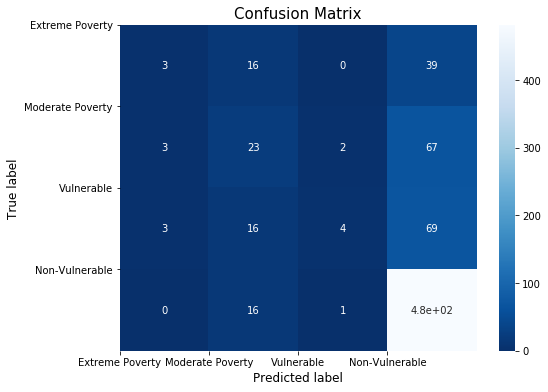

In [43]:
plot_confusion_matrix(y_test, rf_pred)

A classification report returns three metrics of model accuracy: 

Precision (the number of true positives divided by the positive predictions), Recall (the number of true positives divided by all of the actual positives), and the F1-Macro score.

As shown above, the precision is pretty good with respect to households in extreme poverty as well as those in the Non-Vulnerable category. It doesn't do so hot for the other two.

This confusion matrix shows the predictions made compared with the where the observations should lie.

Unfortunately, looking at this shows us that the model learned to predict mostly towards the non-vulnerable state of poverty. This makes sense, since most of the data lies in that classifier, but we had hoped it would have learned better from the other variables to predict accurately the middle classes as well.

Imbalanced Data

We can try to compensate for this problem by using weights in our modeling. We are going to add weights that will try to put more emphasis on predicting the lower income groups, and less on the non-vulnerable class.

In [44]:
weights = {1:4, 2:1, 3:1.2, 4:.25}
RandF_weighted = RandomForestClassifier(n_estimators = 300, 
                                        min_samples_split = 4, 
                                        min_samples_leaf = 2, 
                                        max_features = 20, 
                                        max_depth = 9, 
                                        criterion = 'gini', 
                                        bootstrap = True)
RandF_weighted.fit(x_train, y_train)
RandF_weighted_pred = RandF_weighted.predict(x_test)
RandF_weighted_report = classification_report(y_test, RandF_weighted_pred)

# Renders Model Report, Compares to Weighted Model
print('Original Random Forest Report \n')
print(rf_report)
print('Weighted Random Forest Report \n')
print(RandF_weighted_report)

Original Random Forest Report 

              precision    recall  f1-score   support

           1       0.33      0.05      0.09        58
           2       0.32      0.24      0.28        95
           3       0.57      0.04      0.08        92
           4       0.73      0.97      0.83       499

   micro avg       0.69      0.69      0.69       744
   macro avg       0.49      0.33      0.32       744
weighted avg       0.63      0.69      0.61       744

Weighted Random Forest Report 

              precision    recall  f1-score   support

           1       0.45      0.09      0.14        58
           2       0.30      0.25      0.27        95
           3       0.44      0.04      0.08        92
           4       0.74      0.95      0.83       499

   micro avg       0.68      0.68      0.68       744
   macro avg       0.48      0.33      0.33       744
weighted avg       0.62      0.68      0.61       744



It looks like after using this method, my model did a little better predicting extreme poverty. This is good, because for policy implications, it's most important to know who is in dire need.

Conclusion and Discussion

Unfortunately, our models are not particularly amazing, but I was able to take the one that did the best and helped it do a little bit better with some basic hyperparameter tuning, and ran the model with weights and oversampled data.

Our model still wasn't very good at predicting extreme poverty. So, for practical use it might be better to use other methods of identification in order to target people in extreme poverty. (or build a better model ;) More data/variables could greatly improve the ability to classify poverty, as the data we had was not strong enough to teach the model to accurately classify the middle classes of poverty. 